In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    precision_score, recall_score, classification_report,
    hamming_loss, jaccard_score
)
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [2]:
# ============================================================================
# SECTION 1: DATA PREPARATION WITH PROPER SPLITS
# ============================================================================

print("="*80)
print("LOADING GOEMOTIONS DATASET")
print("="*80)

# Load GoEmotions dataset
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")
emotion_labels = dataset["train"].features["labels"].feature.names
NUM_LABELS = len(emotion_labels)

# Create label mappings
id2label = {i: label for i, label in enumerate(emotion_labels)}
label2id = {label: i for i, label in enumerate(emotion_labels)}

print(f"Total emotions: {NUM_LABELS}")
print(f"Emotion labels: {emotion_labels}")
print(f"\nDataset splits:")
print(f"  Train: {len(dataset['train'])} samples")
print(f"  Validation: {len(dataset['validation'])} samples")
print(f"  Test: {len(dataset['test'])} samples")


def convert_labels_to_multihot(batch):
    """Convert multi-label format to binary vector"""
    label_vector = np.zeros(NUM_LABELS, dtype=np.float32)
    for label_id in batch["labels"]:
        label_vector[label_id] = 1.0
    return {"labels": label_vector.tolist()}


# Apply conversion
dataset_encoded = dataset.map(convert_labels_to_multihot)


LOADING GOEMOTIONS DATASET


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Total emotions: 28
Emotion labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

Dataset splits:
  Train: 43410 samples
  Validation: 5426 samples
  Test: 5427 samples


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [3]:
# ============================================================================
# SECTION 2: BASELINE MODEL (TF-IDF + LOGISTIC REGRESSION)
# ============================================================================

print("\n" + "="*80)
print("TRAINING BASELINE MODEL (TF-IDF + Logistic Regression)")
print("="*80)

# Prepare text data
train_texts = dataset_encoded["train"]["text"]
train_labels = np.array([x for x in dataset_encoded["train"]["labels"]])

test_texts = dataset_encoded["test"]["text"]
test_labels = np.array([x for x in dataset_encoded["test"]["labels"]])

# TF-IDF Vectorization
print("\nVectorizing text with TF-IDF...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_texts)
X_test_tfidf = tfidf.transform(test_texts)

# Train baseline classifier
print("Training baseline classifier...")
baseline_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
baseline_model.fit(X_train_tfidf, train_labels)

# Evaluate baseline
print("\nEvaluating baseline model...")
baseline_pred = baseline_model.predict(X_test_tfidf)
baseline_pred_proba = baseline_model.predict_proba(X_test_tfidf)

baseline_metrics = {
    "micro_f1": f1_score(test_labels, baseline_pred, average="micro"),
    "macro_f1": f1_score(test_labels, baseline_pred, average="macro"),
    "micro_precision": precision_score(test_labels, baseline_pred, average="micro"),
    "micro_recall": recall_score(test_labels, baseline_pred, average="micro"),
    "hamming_loss": hamming_loss(test_labels, baseline_pred),
    "jaccard": jaccard_score(test_labels, baseline_pred, average="micro")
}

print("\n--- BASELINE MODEL RESULTS ---")
for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")


TRAINING BASELINE MODEL (TF-IDF + Logistic Regression)

Vectorizing text with TF-IDF...
Training baseline classifier...

Evaluating baseline model...

--- BASELINE MODEL RESULTS ---
micro_f1: 0.4099
macro_f1: 0.2258
micro_precision: 0.7224
micro_recall: 0.2861
hamming_loss: 0.0343
jaccard: 0.2578


In [4]:
# ============================================================================
# SECTION 3: TRANSFORMER MODEL (DISTILBERT)
# ============================================================================

print("\n" + "="*80)
print("PREPARING DISTILBERT MODEL")
print("="*80)

model_checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_checkpoint)
MAX_LENGTH = 512

def tokenize_and_prepare_input(examples):
    """Tokenize text for transformer input"""
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

# Tokenize datasets
tokenized_datasets = dataset_encoded.map(
    tokenize_and_prepare_input,
    batched=True,
)


PREPARING DISTILBERT MODEL


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [5]:
# 2. CALCULATE SMOOTHED CLASS WEIGHTS (Square Root)
labels_matrix = np.array(tokenized_datasets['train']['labels'])
weights_per_class = []

for i in range(labels_matrix.shape[1]):
    counts = np.bincount(labels_matrix[:, i].astype(int))
    if len(counts) > 1 and counts[1] > 0:
        # Standard Inverse Weight
        raw_weight = len(labels_matrix) / (2 * counts[1])
        # APPLY SQUARE ROOT TO REDUCE AGGRESSIVENESS
        smoothed_weight = np.sqrt(raw_weight)
        weights_per_class.append(smoothed_weight)
    else:
        weights_per_class.append(1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pos_weights = torch.tensor(weights_per_class, dtype=torch.float).to(device)

In [6]:
# 3. WEIGHTED LOSS TRAINER
class JournalEmotionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Ensure labels are of type torch.float for BCEWithLogitsLoss
        labels = labels.to(torch.float)
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [7]:
# 4. LOAD MODEL
model = DistilBertForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

print(f"\nModel classifier output dimension: {model.classifier.out_features}")
print("Loss function: Binary Cross Entropy with Logits (BCEWithLogitsLoss)")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model classifier output dimension: 28
Loss function: Binary Cross Entropy with Logits (BCEWithLogitsLoss)


In [8]:
# ============================================================================
# SECTION 4: TRAINING WITH PROPER METRICS
# ============================================================================

# 5. TRAINING ARGUMENTS
training_args = TrainingArguments(
    output_dir="./journal_model_smoothed",
    num_train_epochs=10,
    per_device_train_batch_size=8,    # Keep at 8 for 512 tokens
    gradient_accumulation_steps=2,    # Effectively batch size 16
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=True,
    report_to="none"
)

# 6. METRICS (Full suite restored)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)

    return {
            # F1 Scores (The main targets)
            "f1_micro": f1_score(labels, preds, average="micro"),
            "f1_macro": f1_score(labels, preds, average="macro"),

            # Precision/Recall (The 'quality' check)
            "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
            "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),

            # Multi-label specific metrics
            "hamming_loss": hamming_loss(labels, preds),

            # Separation ability (How well it ranks emotions)
            "roc_auc": roc_auc_score(labels, probs, average="micro") if len(np.unique(labels)) > 1 else 0.0
        }

# 7. START TRAINING
trainer = JournalEmotionTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

# Train the model
trainer.train()


STARTING TRAINING


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro,Hamming Loss,Roc Auc,Runtime,Samples Per Second,Steps Per Second
1,0.202600,0.186454,0.579746,0.520137,0.542315,0.622727,0.037913,0.953844,22.670900,239.338000,29.950000
2,0.164600,0.180917,0.586574,0.523858,0.545161,0.634796,0.037577,0.957146,22.652600,239.531000,29.974000
3,0.127700,0.191980,0.577196,0.513110,0.523542,0.643103,0.039565,0.954579,22.591200,240.182000,30.056000
4,0.102300,0.217598,0.565171,0.514436,0.521537,0.616771,0.039854,0.951164,22.688400,239.153000,29.927000


TrainOutput(global_step=10856, training_loss=0.16016152753668317, metrics={'train_runtime': 2454.6385, 'train_samples_per_second': 176.849, 'train_steps_per_second': 11.057, 'total_flos': 2.301230434369536e+16, 'train_loss': 0.16016152753668317, 'epoch': 4.0})

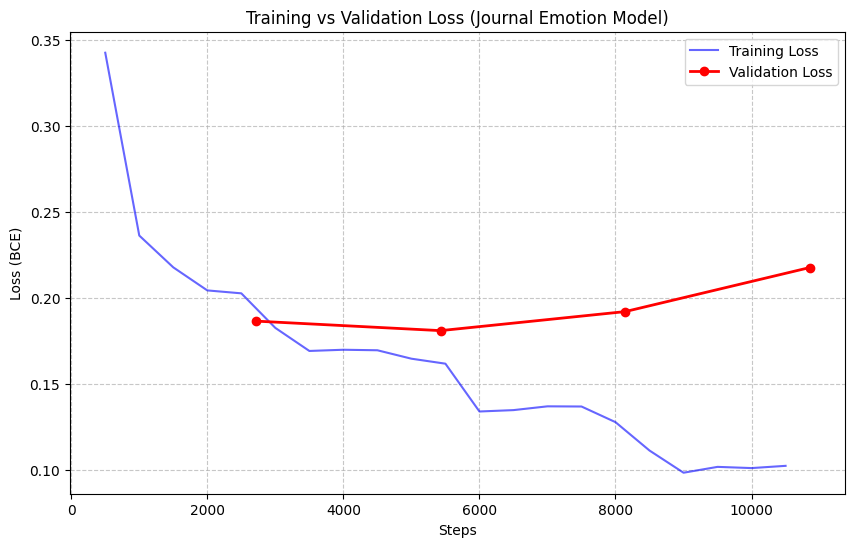

In [9]:
def plot_training_history(trainer):
    # Extract logs
    history = trainer.state.log_history

    train_loss = [log["loss"] for log in history if "loss" in log]
    train_steps = [log["step"] for log in history if "loss" in log]

    val_loss = [log["eval_loss"] for log in history if "eval_loss" in log]
    val_steps = [log["step"] for log in history if "eval_loss" in log]

    plt.figure(figsize=(10, 6))

    # Plot Training Loss
    plt.plot(train_steps, train_loss, label="Training Loss", color="blue", alpha=0.6)

    # Plot Validation Loss (Evaluation happens at the end of each epoch)
    plt.plot(val_steps, val_loss, label="Validation Loss", color="red", marker='o', linewidth=2)

    plt.title("Training vs Validation Loss (Journal Emotion Model)")
    plt.xlabel("Steps")
    plt.ylabel("Loss (BCE)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# After training is complete, call the function
plot_training_history(trainer)

In [10]:
# ============================================================================
# SECTION 5: TEST SET EVALUATION (CRITICAL FOR RESEARCH)
# ============================================================================

print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

# Evaluate on test set
test_results = trainer.evaluate(tokenized_datasets["test"])

print("\n--- DISTILBERT TEST RESULTS ---")
for metric, value in test_results.items():
    if metric.startswith("eval_"):
        print(f"{metric.replace('eval_', '')}: {value:.4f}")


EVALUATING ON TEST SET



--- DISTILBERT TEST RESULTS ---
loss: 0.1824
f1_micro: 0.5787
f1_macro: 0.5136
precision_micro: 0.5374
recall_micro: 0.6268
hamming_loss: 0.0380
roc_auc: 0.9560
runtime: 28.8028
samples_per_second: 188.4190
steps_per_second: 23.5740


In [11]:
# ============================================================================
# SECTION 6: PER-EMOTION ANALYSIS (IMPORTANT FOR DISCUSSION)
# ============================================================================

print("\n" + "="*80)
print("PER-EMOTION PERFORMANCE ANALYSIS")
print("="*80)

# Get predictions for test set
predictions = trainer.predict(tokenized_datasets["test"])
logits = predictions.predictions
labels = predictions.label_ids

probabilities = 1 / (1 + np.exp(-logits))
pred_labels = (probabilities > 0.5).astype(int)

# Calculate per-emotion F1 scores
per_emotion_f1 = []
for i, emotion in enumerate(emotion_labels):
    f1 = f1_score(labels[:, i], pred_labels[:, i])
    per_emotion_f1.append((emotion, f1))

per_emotion_f1.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 Best Performing Emotions:")
for emotion, f1 in per_emotion_f1[:10]:
    print(f"  {emotion:15s}: {f1:.4f}")

print("\nBottom 10 Worst Performing Emotions:")
for emotion, f1 in per_emotion_f1[-10:]:
    print(f"  {emotion:15s}: {f1:.4f}")



PER-EMOTION PERFORMANCE ANALYSIS



Top 10 Best Performing Emotions:
  gratitude      : 0.8904
  amusement      : 0.8322
  love           : 0.8054
  admiration     : 0.6954
  neutral        : 0.6639
  remorse        : 0.6581
  fear           : 0.6404
  optimism       : 0.5684
  surprise       : 0.5495
  curiosity      : 0.5485

Bottom 10 Worst Performing Emotions:
  confusion      : 0.4026
  grief          : 0.4000
  excitement     : 0.3966
  approval       : 0.3944
  nervousness    : 0.3729
  annoyance      : 0.3628
  embarrassment  : 0.3614
  relief         : 0.3415
  realization    : 0.3043
  disappointment : 0.2945


In [15]:
# ============================================================================
# SECTION 7: COMPARISON TABLE (FOR DISSERTATION)
# ============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    "Metric": ["Micro F1", "Macro F1", "Micro Precision", "Micro Recall", "Hamming Loss"],
    "Baseline (TF-IDF + LR)": [
        baseline_metrics["micro_f1"],
        baseline_metrics["macro_f1"],
        baseline_metrics["micro_precision"],
        baseline_metrics["micro_recall"],
        baseline_metrics["hamming_loss"]
    ],
    "DistilBERT": [
        test_results["eval_f1_micro"],
        test_results["eval_f1_macro"],
        test_results["eval_precision_micro"],
        test_results["eval_recall_micro"],
        test_results["eval_hamming_loss"]
    ]
})

print("\n", comparison_df.to_string(index=False))

# Calculate improvement
improvement = ((test_results["eval_f1_micro"] - baseline_metrics["micro_f1"])
               / baseline_metrics["micro_f1"] * 100)
print(f"\nRelative Improvement: {improvement:.2f}%")


MODEL COMPARISON SUMMARY

          Metric  Baseline (TF-IDF + LR)  DistilBERT
       Micro F1                0.409914    0.578659
       Macro F1                0.225833    0.513623
Micro Precision                0.722377    0.537388
   Micro Recall                0.286143    0.626797
   Hamming Loss                0.034313    0.038018

Relative Improvement: 41.17%


In [16]:
# ============================================================================
# SECTION 9: JOURNAL ENTRY TESTING (RESEARCH VALIDATION)
# ============================================================================

print("\n" + "="*80)
print("TESTING ON JOURNAL-STYLE TEXT")
print("="*80)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Test on different types of journal entries
journal_samples = [
    "I finished the project today! I'm so proud of myself and excited for what's next, but I'm also relieved the stress is over.",
    "Today was difficult. I feel overwhelmed by everything happening at once and I'm not sure how to handle it all.",
    "Had a quiet day at home. Nothing special happened but I feel content and peaceful.",
    "I'm angry at myself for procrastinating again. This always happens and I don't know why I can't change."
]

print("\nAnalyzing journal entries:\n")

for idx, entry in enumerate(journal_samples, 1):
    print(f"Entry {idx}: \"{entry[:60]}...\"")

    test_input = tokenizer(
        entry,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**test_input)
        logits = outputs.logits

    probabilities = torch.sigmoid(logits).squeeze().cpu().numpy()

    # Get top 5 emotions
    top_indices = np.argsort(probabilities)[-5:][::-1]

    print("  Top 5 Emotions:")
    for i in top_indices:
        print(f"    {emotion_labels[i]:15s}: {probabilities[i]*100:.2f}%")
    print()



TESTING ON JOURNAL-STYLE TEXT

Analyzing journal entries:

Entry 1: "I finished the project today! I'm so proud of myself and exc..."
  Top 5 Emotions:
    pride          : 94.40%
    joy            : 59.43%
    relief         : 44.03%
    admiration     : 40.99%
    gratitude      : 24.74%

Entry 2: "Today was difficult. I feel overwhelmed by everything happen..."
  Top 5 Emotions:
    confusion      : 65.18%
    disappointment : 55.62%
    sadness        : 47.48%
    realization    : 27.49%
    nervousness    : 14.90%

Entry 3: "Had a quiet day at home. Nothing special happened but I feel..."
  Top 5 Emotions:
    joy            : 94.00%
    relief         : 70.03%
    caring         : 25.93%
    gratitude      : 14.44%
    neutral        : 10.47%

Entry 4: "I'm angry at myself for procrastinating again. This always h..."
  Top 5 Emotions:
    anger          : 90.00%
    annoyance      : 61.83%
    confusion      : 17.81%
    disgust        : 12.56%
    disappointment : 11.88%



In [25]:
# ============================================================================
# SECTION 8: SAVE MODEL AND RESULTS (OPTIMIZED)
# ============================================================================

save_path = "/content/drive/MyDrive/models/emotion_model_final_1"

# Save model with safetensors format (faster, safer)
print("\nSaving model with safetensors format...")
model.save_pretrained(save_path, safe_serialization=True)
tokenizer.save_pretrained(save_path)

# Save results for dissertation
results_summary = {
    "baseline_metrics": baseline_metrics,
    "transformer_metrics": {k.replace("eval_", ""): v for k, v in test_results.items()},
    "per_emotion_f1": per_emotion_f1,
    "improvement_percentage": improvement
}

import json
with open(f"{save_path}/results_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

# Add metadata for production use
metadata = {
    "model_name": "DistilBERT Multi-Label Emotion Detection",
    "base_model": "distilbert-base-uncased",
    "dataset": "GoEmotions (simplified)",
    "task": "multi-label-classification",
    "num_labels": NUM_LABELS,
    "emotions": emotion_labels,
    "max_length": MAX_LENGTH,
    "training_epochs": 3,
    "best_micro_f1": test_results["eval_f1_micro"],
    "format": "safetensors",
    "framework": "transformers",
    "pytorch_version": torch.__version__,
    "date_trained": "2024"
}

with open(f"{save_path}/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Model saved to {save_path}")
print(f"  Format: Safetensors (optimized for production)")
print(f"  Files saved:")
print(f"    - model.safetensors (model weights)")
print(f"    - config.json (model configuration)")
print(f"    - tokenizer files (vocab.txt, tokenizer_config.json, etc.)")
print(f"    - results_summary.json (training metrics)")
print(f"    - metadata.json (model information)")


Saving model with safetensors format...

✓ Model saved to /content/drive/MyDrive/models/emotion_model_final_1
  Format: Safetensors (optimized for production)
  Files saved:
    - model.safetensors (model weights)
    - config.json (model configuration)
    - tokenizer files (vocab.txt, tokenizer_config.json, etc.)
    - results_summary.json (training metrics)
    - metadata.json (model information)


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
